In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
from scipy.interpolate import interp1d
from scipy.ndimage import convolve1d, gaussian_filter1d
import pdb

In [3]:
import itertools
from pyuoi.linear_model.var import VAR, form_lag_matrix
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd

In [4]:
import sys
sys.path.append('/home/akumar/nse/localization')

In [5]:
from loaders import load_peanut

In [6]:
filter_dict = {'none': lambda x, **kwargs: x, 'gaussian': gaussian_filter1d}

In [7]:
def filter_by_dict(df, root_key, dict_filter):

    col = df[root_key].values

    filtered_idxs = []

    for i, c in enumerate(col):
        match = True
        for key, val in dict_filter.items():
            if c[key] != val:
                match = False
        if match:
            filtered_idxs.append(i)

    return df.iloc[filtered_idxs]

# Shortcut to apply multiple filters to pandas dataframe
def apply_df_filters(dtfrm, invert=False, **kwargs):

    filtered_df = dtfrm

    for key, value in kwargs.items():

        # If the value is the dict
        if type(value) == dict:

            filtered_df = filter_by_dict(filtered_df, key, value)

        else:
            if type(value) == list:
                if invert:
                    filtered_df = filtered_df.loc[np.invert(filtered_df[key].isin(value))]
                else:
                    filtered_df = filtered_df.loc[filtered_df[key].isin(value)]
            else:
                if invert:
                    filtered_df = filtered_df.loc[filtered_df[key] != value]
                else:
                    filtered_df = filtered_df.loc[filtered_df[key] == value]

    return filtered_df


In [8]:
from decoders import lr_decoder

In [9]:
fpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

### Initial decoding

In [10]:
# First check: Number of units retained as a function of spike threshold

In [12]:
units_retained = []
for spike_threshold in np.linspace(0, 1000, 11).astype(int):
    dat = load_peanut(fpath, 2, spike_threshold)
    units_retained.append(dat['spike_rates'].shape[1])

In [13]:
units_retained

[69, 63, 54, 51, 47, 42, 39, 37, 37, 35, 34]

In [23]:
# Sweep over bin_sizes, filtering parameters, lag, decodingwindow
bin_widths = [25, 50, 100, 200, 500]
filters = [('none', {})]
filters.extend([('gaussian', {'sigma':sigma}) for sigma in [50, 100, 250, 500]])

loader_params = list(itertools.product(bin_widths, filters))

lags = np.linspace(-15, 15, 7).astype(int)
decoding_windows = [1, 3, 6, 10, 25]

decoding_params = list(itertools.product(lags, decoding_windows))
n_cv = 5

results_list = []

for i, loader_param in tqdm(enumerate(loader_params)):
    dat = load_peanut(fpath, 2, spike_threshold=200, bin_width=loader_param[0], 
                  filter_fn=loader_param[1][0], **loader_param[1][1])

    cv = KFold(n_cv, shuffle=False)
    fold_idx = 0
        
    for train_idxs, test_idxs in cv.split(dat['spike_rates']):
        for j, decoding_param in enumerate(decoding_params):
            xtrain = dat['spike_rates'][train_idxs]
            xtest = dat['spike_rates'][test_idxs]
            
            # Add axis at the end since position is 1D
            ztrain = dat['behavior'][train_idxs]
            ztest = dat['behavior'][test_idxs]

            lr_r2_, _, _, _ = lr_decoder(xtest, xtrain, ztest, ztrain, 
                                   decoding_param[0], decoding_param[0],
                                   decoding_param[1])
            result = {}
            result['bin_width'] = loader_param[0]
            result['filter'] = loader_param[1][0]
            result['filter_kwarg'] = loader_param[1][1]
            result['fold_idx']= fold_idx
            result['lag'] = decoding_param[0]
            result['decoding_window'] = decoding_param[1]
            result['r2'] = lr_r2_
            results_list.append(result)
        fold_idx += 1



25it [02:10,  5.21s/it]


In [25]:
decoding_results = pd.DataFrame(results_list)

In [26]:
np.min(decoding_results['r2'].values)

-1.4055448481785482

In [27]:
np.max(decoding_results['r2'].values)

0.9644385999321736

In [28]:
# r2 as a function of lag

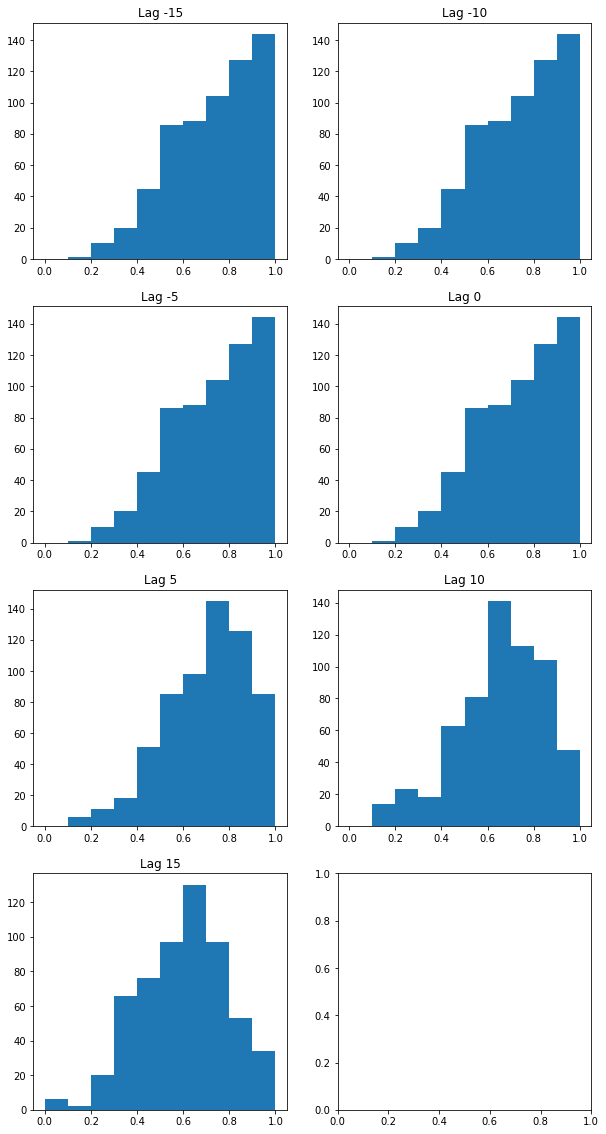

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i in range(len(lags)):
    df_ = decoding_results.loc[decoding_results['lag'] == lags[i]]
    a = ax[np.unravel_index(i, (4, 2))]
    a.hist(df_['r2'].values, range=(0, 1))
    a.set_title('Lag %d' % lags[i])

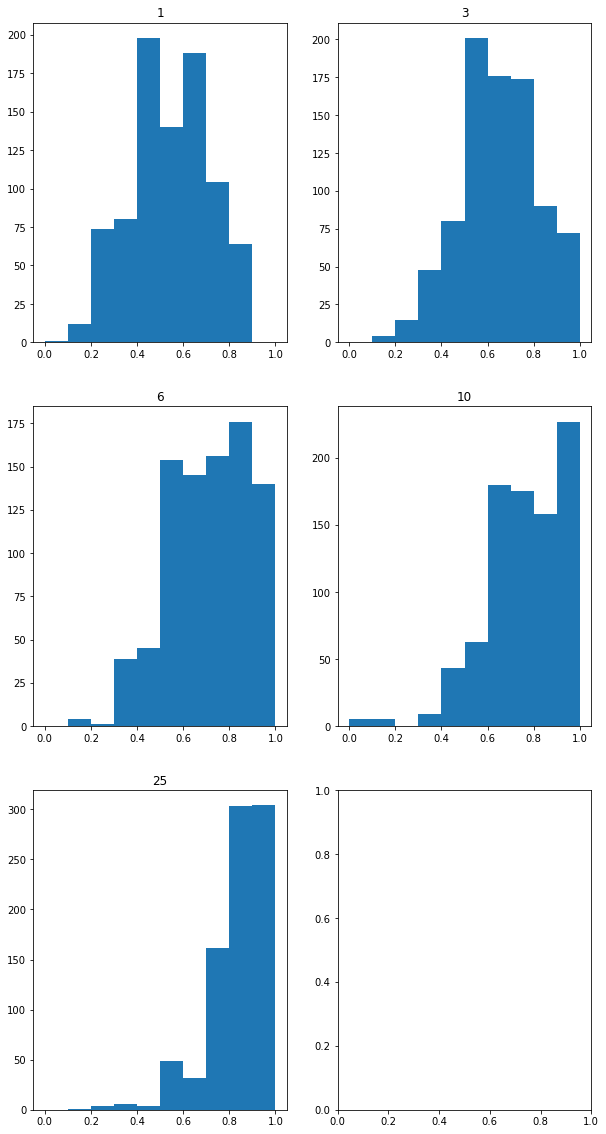

In [32]:
# r2 as a function of decoding window
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
for i in range(len(decoding_windows)):
    df_ = decoding_results.loc[decoding_results['decoding_window'] == decoding_windows[i]]
    a = ax[np.unravel_index(i, (3, 2))]
    a.hist(df_['r2'].values, range=(0, 1))
    a.set_title(decoding_windows[i])

In [ ]:
# Want to use longest decoding window...

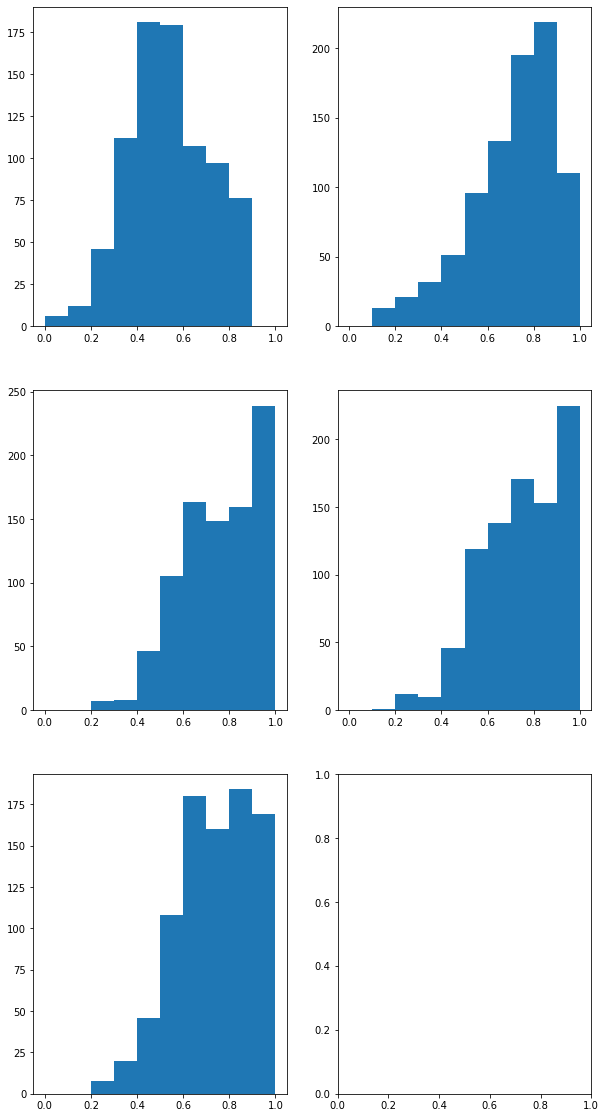

In [33]:
# As a function of fold_idx (to make sure there is nothing funky going on)
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
for i in range(n_cv):
    df_ = decoding_results.loc[decoding_results['fold_idx'] == i]
    a = ax[np.unravel_index(i, (3, 2))]
    a.hist(df_['r2'].values, range=(0, 1))


In [34]:
len(bin_widths)

5

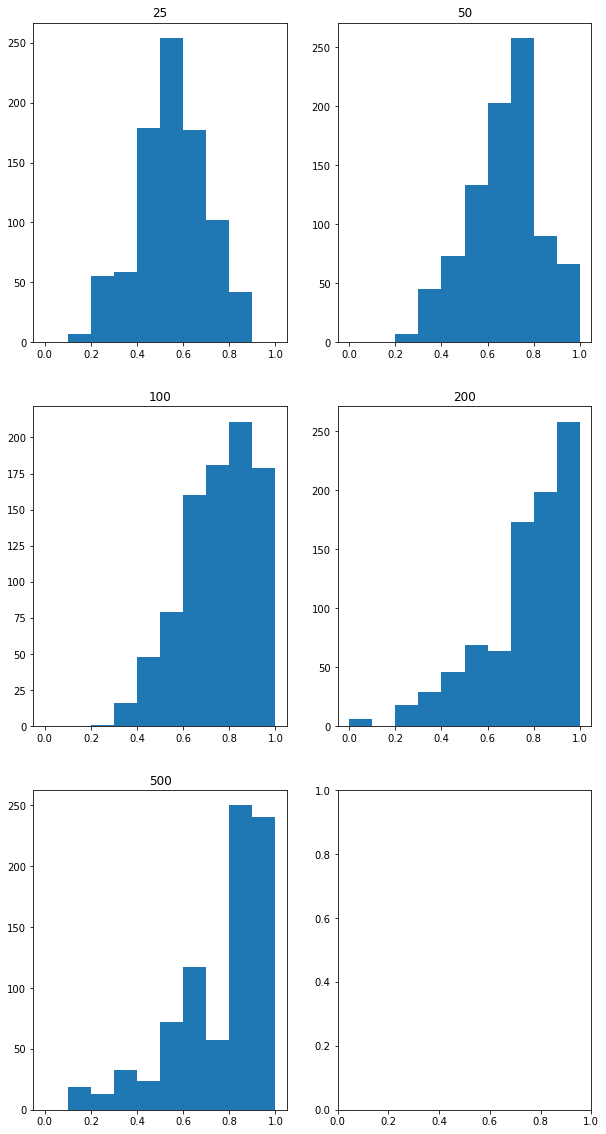

In [35]:
# As a function of bin_width
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
for i in range(len(bin_widths)):
    df_ = decoding_results.loc[decoding_results['bin_width'] == bin_widths[i]]
    a = ax[np.unravel_index(i, (3, 2))]
    a.hist(df_['r2'].values, range=(0, 1))
    a.set_title(bin_widths[i])

In [188]:
# Use bin width 200 ms

In [189]:
# Set bin width = 200 ms, decoding_window = 10, and plot as a function of filter_fn

In [36]:
filters

[('none', {}),
 ('gaussian', {'sigma': 50}),
 ('gaussian', {'sigma': 100}),
 ('gaussian', {'sigma': 250}),
 ('gaussian', {'sigma': 500})]

In [37]:
list(decoding_results.keys())

['bin_width',
 'filter',
 'filter_kwarg',
 'fold_idx',
 'lag',
 'decoding_window',
 'r2']

In [38]:
lags

array([-15, -10,  -5,   0,   5,  10,  15])

In [39]:
df_.loc[df_['lag'] == 15]['r2'].values

array([-0.27881727, -0.2587847 , -0.38641209, -0.360431  , -0.52947538,
        0.24261711,  0.36375884,  0.40747485,  0.36967462, -0.58668324,
        0.39266391,  0.61619797,  0.58065139,  0.50292109,  0.31493681,
        0.33836161,  0.52286838,  0.56900016,  0.55387618,  0.1411909 ,
        0.33821842,  0.56845399,  0.59025838,  0.47933752,  0.37335247,
       -0.38084915, -0.26469056, -0.39076242, -0.5344883 , -1.40554485,
        0.36919471,  0.42134121,  0.37859455,  0.31631112, -0.82797461,
        0.58553837,  0.65427722,  0.58480667,  0.50528085,  0.42805296,
        0.49451142,  0.56797752,  0.57022866,  0.51315613,  0.24642234,
        0.48586158,  0.62333431,  0.61767912,  0.34109847,  0.36354406,
       -0.38084915, -0.26469056, -0.39076242, -0.5344883 , -1.40554485,
        0.36919471,  0.42134121,  0.37859455,  0.31631112, -0.82797461,
        0.58553837,  0.65427722,  0.58480667,  0.50528085,  0.42805296,
        0.49451142,  0.56797752,  0.57022866,  0.51315613,  0.24

(35, 7)
0.9419782763875105
(35, 7)
0.949669763889174
(35, 7)
0.949669763889174
(35, 7)
0.949669763889174
(35, 7)
0.949669763889174


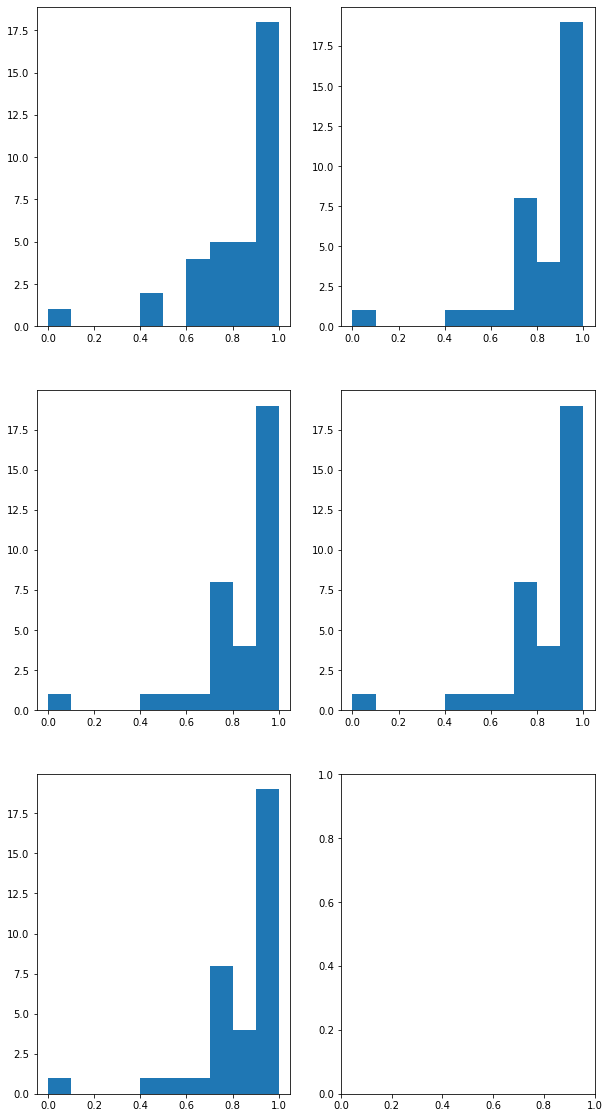

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(10, 20))

for i, filter_ in enumerate(filters):
#     if i == 1:
#         pdb.set_trace()
    df_ = apply_df_filters(decoding_results, bin_width=200, decoding_window=10, filter=filter_[0],
                           filter_kwarg=filter_[1])
    print(df_.shape)
    print(np.max(df_['r2'].values))
    a = ax[np.unravel_index(i, (3, 2))]
    a.hist(df_['r2'].values, range=(0, 1))

In [ ]:
# What does bin width level smoothing look like?

### Dimreduc

In [41]:
from sklearn.decomposition import PCA
from dca.dca import DynamicalComponentsAnalysis as DCA
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [42]:
fpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [43]:
bin_widths = [25, 50, 100]
filters = [('none', {})]

loader_params = list(itertools.product(bin_widths, filters))
lag = 0
decoding_windows = [3, 6, 10]

n_cv = 5

dim_vals = np.arange(1, 20)
T = [1, 3, 5]

In [45]:
results_list = []

for i, loader_param in tqdm(enumerate(loader_params)):
    dat = load_peanut(fpath, 2, spike_threshold=200, bin_width=loader_param[0], 
                  filter_fn=loader_param[1][0], **loader_param[1][1])

    cv = KFold(n_cv, shuffle=False)
    fold_idx = 0    
    for train_idxs, test_idxs in cv.split(dat['spike_rates']):

        xtrain = dat['spike_rates'][train_idxs]
        xtest = dat['spike_rates'][test_idxs]

        # Add axis at the end since position is 1D
        ztrain = dat['behavior'][train_idxs]
        ztest = dat['behavior'][test_idxs]

        pcaobj = PCA()
        pcaobj.fit(xtrain)

        for j, dim_val in tqdm(enumerate(dim_vals)):
            for k, T_ in enumerate(T):

                xtrainpca = xtrain @ pcaobj.components_[0:dim_val, :].T
                xtestpca = xtest @ pcaobj.components_[0:dim_val, :].T

                dcaobj = DCA(T=T_, d=dim_val)
                dcaobj.fit(xtrain)
                xtraindca = xtrain @ dcaobj.coef_
                xtestdca = xtest @ dcaobj.coef_

                kcaobj = KCA(T=2*T_, d=dim_val)
                kcaobj.fit(xtrain)
                xtrainkca = xtrain @ kcaobj.coef_
                xtestkca = xtest @ kcaobj.coef_
                                
                for h, decoding_window in enumerate(decoding_windows):
                    lr_r2_pca, _, _, _ = lr_decoder(xtestpca, xtrainpca, ztest, ztrain, 
                                              lag, lag, decoding_window)
                    lr_r2_dca, _, _, _ = lr_decoder(xtestdca, xtraindca, ztest, ztrain, 
                                              lag, lag, decoding_window)
                    lr_r2_kca, _, _, _ = lr_decoder(xtestkca, xtrainkca, ztest, ztrain, 
                                              lag, lag, decoding_window)

                    result = {}
                    
                    result['bin_width'] = loader_param[0]
                    result['filter'] = loader_param[1][0]
                    result['filter_kwarg'] = loader_param[1][1]
                    result['lag'] = lag
                    result['decoding_window'] = decoding_window
                    
                    result['fold_idx']= fold_idx
                    result['dim_val'] = dim_val
                    result['T'] = T_
                    result['r2_pca'] = lr_r2_pca
                    result['r2_dca'] = lr_r2_dca
                    result['r2_kca'] = lr_r2_kca
                    
                    result['pca_loadings'] = np.linalg.norm(pcaobj.components_[0:dim_val, :].T, axis=-1)
                    result['dca_loadings'] = np.linalg.norm(dcaobj.coef_, axis=-1)
                    result['kca_loadings'] = np.linalg.norm(kcaobj.coef_, axis=-1)
                    results_list.append(result)

        fold_idx += 1
        print('Fold %d' % fold_idx)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.17it/s]
2it [00:01,  1.38it/s]
3it [00:02,  1.14it/s]
4it [00:03,  1.08s/it]
5it [00:05,  1.14s/it]
6it [00:06,  1.23s/it]
7it [00:07,  1.22s/it]
8it [00:09,  1.28s/it]
9it [00:10,  1.36s/it]
10it [00:12,  1.42s/it]
11it [00:14,  1.56s/it]
12it [00:16,  1.69s/it]
13it [00:18,  1.79s/it]
14it [00:20,  1.93s/it]
15it [00:22,  2.05s/it]
16it [00:24,  2.12s/it]
17it [00:27,  2.25s/it]
18it [00:30,  2.49s/it]
19it [00:33,  1.74s/it]


Fold 1



0it [00:00, ?it/s]
1it [00:00,  2.06it/s]
2it [00:01,  1.35it/s]
3it [00:02,  1.12it/s]
4it [00:03,  1.05it/s]
5it [00:04,  1.06s/it]
6it [00:05,  1.10s/it]
7it [00:07,  1.21s/it]
8it [00:08,  1.28s/it]
9it [00:10,  1.36s/it]
10it [00:11,  1.44s/it]
11it [00:13,  1.50s/it]
12it [00:15,  1.59s/it]
13it [00:17,  1.73s/it]
14it [00:19,  1.91s/it]
15it [00:22,  2.10s/it]
16it [00:25,  2.35s/it]
17it [00:27,  2.44s/it]
18it [00:30,  2.45s/it]
19it [00:33,  1.74s/it]


Fold 2



0it [00:00, ?it/s]
1it [00:00,  2.22it/s]
2it [00:01,  1.34it/s]
3it [00:02,  1.07it/s]
4it [00:03,  1.01it/s]
5it [00:04,  1.10s/it]
6it [00:06,  1.14s/it]
7it [00:07,  1.22s/it]
8it [00:08,  1.30s/it]
9it [00:10,  1.42s/it]
10it [00:12,  1.51s/it]
11it [00:14,  1.61s/it]
12it [00:16,  1.75s/it]
13it [00:18,  1.91s/it]
14it [00:20,  2.05s/it]
15it [00:23,  2.15s/it]
16it [00:25,  2.29s/it]
17it [00:28,  2.44s/it]
18it [00:31,  2.58s/it]
19it [00:34,  1.83s/it]


Fold 3



0it [00:00, ?it/s]
1it [00:00,  1.86it/s]
2it [00:01,  1.34it/s]
3it [00:02,  1.11it/s]
4it [00:03,  1.04s/it]
5it [00:04,  1.10s/it]
6it [00:06,  1.17s/it]
7it [00:07,  1.25s/it]
8it [00:09,  1.31s/it]
9it [00:10,  1.40s/it]
10it [00:12,  1.51s/it]
11it [00:14,  1.60s/it]
12it [00:16,  1.80s/it]
13it [00:18,  1.94s/it]
14it [00:21,  2.04s/it]
15it [00:23,  2.09s/it]
16it [00:25,  2.15s/it]
17it [00:27,  2.19s/it]
18it [00:30,  2.25s/it]
19it [00:33,  1.74s/it]


Fold 4



0it [00:00, ?it/s]
1it [00:00,  2.22it/s]
2it [00:01,  1.61it/s]
3it [00:02,  1.23it/s]
4it [00:03,  1.10it/s]
5it [00:04,  1.01s/it]
6it [00:05,  1.12s/it]
7it [00:07,  1.19s/it]
8it [00:08,  1.28s/it]
9it [00:10,  1.39s/it]
10it [00:12,  1.52s/it]
11it [00:13,  1.60s/it]
12it [00:15,  1.63s/it]
13it [00:17,  1.82s/it]
14it [00:19,  1.88s/it]
15it [00:22,  1.98s/it]
16it [00:24,  2.19s/it]
17it [00:27,  2.27s/it]
18it [00:29,  2.23s/it]
19it [00:32,  1.69s/it]
1it [02:48, 168.10s/it]

Fold 5



0it [00:00, ?it/s]
1it [00:00,  2.77it/s]
2it [00:01,  1.80it/s]
3it [00:01,  1.46it/s]
4it [00:02,  1.23it/s]
5it [00:03,  1.15it/s]
6it [00:04,  1.15it/s]
7it [00:05,  1.11it/s]
8it [00:06,  1.02it/s]
9it [00:08,  1.08s/it]
10it [00:09,  1.14s/it]
11it [00:10,  1.18s/it]
12it [00:12,  1.26s/it]
13it [00:13,  1.32s/it]
14it [00:15,  1.47s/it]
15it [00:17,  1.59s/it]
16it [00:19,  1.72s/it]
17it [00:21,  1.76s/it]
18it [00:23,  1.83s/it]
19it [00:25,  1.33s/it]


Fold 1



0it [00:00, ?it/s]
1it [00:00,  2.44it/s]
2it [00:01,  1.82it/s]
3it [00:01,  1.53it/s]
4it [00:02,  1.35it/s]
5it [00:03,  1.18it/s]
6it [00:04,  1.05it/s]
7it [00:05,  1.03it/s]
8it [00:07,  1.03s/it]
9it [00:08,  1.12s/it]
10it [00:09,  1.19s/it]
11it [00:11,  1.25s/it]
12it [00:12,  1.30s/it]
13it [00:14,  1.42s/it]
14it [00:15,  1.48s/it]
15it [00:17,  1.61s/it]
16it [00:19,  1.74s/it]
17it [00:21,  1.84s/it]
18it [00:23,  1.86s/it]
19it [00:26,  1.38s/it]


Fold 2



0it [00:00, ?it/s]
1it [00:00,  2.74it/s]
2it [00:01,  1.88it/s]
3it [00:01,  1.55it/s]
4it [00:02,  1.26it/s]
5it [00:03,  1.09it/s]
6it [00:05,  1.01it/s]
7it [00:06,  1.00s/it]
8it [00:07,  1.02s/it]
9it [00:08,  1.15s/it]
10it [00:09,  1.18s/it]
11it [00:11,  1.22s/it]
12it [00:12,  1.25s/it]
13it [00:14,  1.42s/it]
14it [00:16,  1.55s/it]
15it [00:18,  1.73s/it]
16it [00:20,  1.89s/it]
17it [00:22,  1.88s/it]
18it [00:24,  1.92s/it]
19it [00:26,  1.41s/it]


Fold 3



0it [00:00, ?it/s]
1it [00:00,  2.97it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.57it/s]
4it [00:02,  1.25it/s]
5it [00:03,  1.12it/s]
6it [00:04,  1.08it/s]
7it [00:06,  1.05s/it]
8it [00:07,  1.17s/it]
9it [00:08,  1.19s/it]
10it [00:10,  1.23s/it]
11it [00:11,  1.23s/it]
12it [00:12,  1.27s/it]
13it [00:14,  1.40s/it]
14it [00:16,  1.48s/it]
15it [00:17,  1.59s/it]
16it [00:20,  1.80s/it]
17it [00:22,  1.88s/it]
18it [00:24,  1.93s/it]
19it [00:26,  1.41s/it]


Fold 4



0it [00:00, ?it/s]
1it [00:00,  3.09it/s]
2it [00:01,  1.79it/s]
3it [00:01,  1.46it/s]
4it [00:02,  1.29it/s]
5it [00:04,  1.07it/s]
6it [00:04,  1.05it/s]
7it [00:06,  1.04s/it]
8it [00:07,  1.08s/it]
9it [00:08,  1.13s/it]
10it [00:09,  1.18s/it]
11it [00:11,  1.21s/it]
12it [00:12,  1.29s/it]
13it [00:14,  1.45s/it]
14it [00:16,  1.52s/it]
15it [00:18,  1.67s/it]
16it [00:20,  1.79s/it]
17it [00:21,  1.76s/it]
18it [00:24,  1.88s/it]
19it [00:26,  1.38s/it]
2it [05:00, 147.16s/it]

Fold 5



0it [00:00, ?it/s]
1it [00:00,  3.39it/s]
2it [00:00,  2.33it/s]
3it [00:01,  1.91it/s]
4it [00:02,  1.64it/s]
5it [00:02,  1.48it/s]
6it [00:03,  1.36it/s]
7it [00:04,  1.26it/s]
8it [00:05,  1.11it/s]
9it [00:07,  1.04s/it]
10it [00:08,  1.10s/it]
11it [00:09,  1.17s/it]
12it [00:10,  1.14s/it]
13it [00:12,  1.22s/it]
14it [00:13,  1.26s/it]
15it [00:15,  1.39s/it]
16it [00:16,  1.45s/it]
17it [00:18,  1.52s/it]
18it [00:20,  1.54s/it]
19it [00:22,  1.16s/it]


Fold 1



0it [00:00, ?it/s]
1it [00:00,  3.41it/s]
2it [00:00,  2.39it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.61it/s]
5it [00:03,  1.45it/s]
6it [00:03,  1.35it/s]
7it [00:04,  1.28it/s]
8it [00:05,  1.21it/s]
9it [00:06,  1.02it/s]
10it [00:08,  1.01it/s]
11it [00:09,  1.09s/it]
12it [00:10,  1.20s/it]
13it [00:12,  1.30s/it]
14it [00:13,  1.39s/it]
15it [00:15,  1.50s/it]
16it [00:17,  1.50s/it]
17it [00:18,  1.59s/it]
18it [00:20,  1.62s/it]
19it [00:22,  1.18s/it]


Fold 2



0it [00:00, ?it/s]
1it [00:00,  3.56it/s]
2it [00:00,  2.08it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.57it/s]
5it [00:03,  1.35it/s]
6it [00:04,  1.26it/s]
7it [00:05,  1.15it/s]
8it [00:06,  1.05it/s]
9it [00:07,  1.04s/it]
10it [00:08,  1.09s/it]
11it [00:09,  1.13s/it]
12it [00:11,  1.18s/it]
13it [00:12,  1.23s/it]
14it [00:14,  1.35s/it]
15it [00:16,  1.48s/it]
16it [00:17,  1.56s/it]
17it [00:19,  1.70s/it]
18it [00:21,  1.68s/it]
19it [00:23,  1.22s/it]


Fold 3



0it [00:00, ?it/s]
1it [00:00,  3.86it/s]
2it [00:00,  2.17it/s]
3it [00:01,  1.75it/s]
4it [00:02,  1.58it/s]
5it [00:03,  1.46it/s]
6it [00:03,  1.42it/s]
7it [00:04,  1.22it/s]
8it [00:05,  1.14it/s]
9it [00:06,  1.05it/s]
10it [00:08,  1.04s/it]
11it [00:09,  1.09s/it]
12it [00:10,  1.12s/it]
13it [00:11,  1.13s/it]
14it [00:12,  1.16s/it]
15it [00:14,  1.34s/it]
16it [00:16,  1.37s/it]
17it [00:17,  1.42s/it]
18it [00:19,  1.57s/it]
19it [00:21,  1.12s/it]


Fold 4



0it [00:00, ?it/s]
1it [00:00,  3.71it/s]
2it [00:00,  2.55it/s]
3it [00:01,  2.06it/s]
4it [00:02,  1.68it/s]
5it [00:03,  1.39it/s]
6it [00:03,  1.41it/s]
7it [00:04,  1.20it/s]
8it [00:05,  1.13it/s]
9it [00:06,  1.08it/s]
10it [00:07,  1.02it/s]
11it [00:08,  1.00s/it]
12it [00:10,  1.05s/it]
13it [00:11,  1.09s/it]
14it [00:12,  1.16s/it]
15it [00:14,  1.22s/it]
16it [00:15,  1.36s/it]
17it [00:17,  1.55s/it]
18it [00:19,  1.51s/it]
19it [00:20,  1.09s/it]
3it [06:50, 136.93s/it]

Fold 5


In [56]:
dimreduc_df = pd.DataFrame(results_list)

In [47]:
# with open('franklab_dimreduc.dat', 'wb') as f:
#     f.write(pickle.dumps(dimreduc_df))

In [48]:
# with open('franklab_dimreduc.dat', 'rb') as f:
#     dimreduc_df = pickle.load(f)

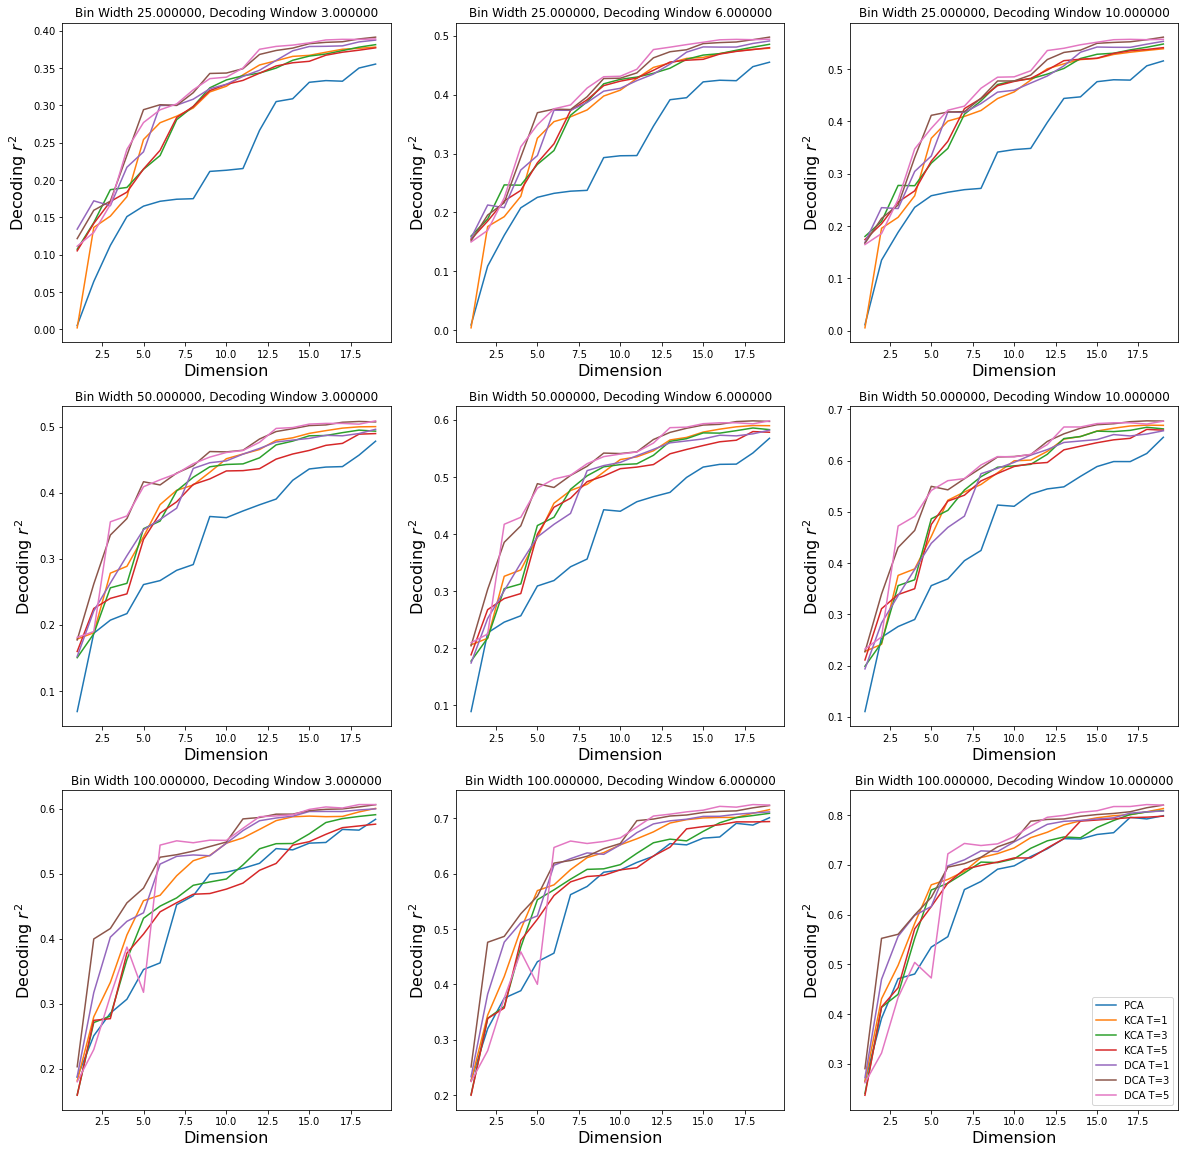

In [58]:
# Plot the r2 vs dim val - no smoothing of firing rates
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for ii, bin_width in enumerate(bin_widths):
    for jj, decoding_window in enumerate(decoding_windows):
        dimreduc_df_ = apply_df_filters(dimreduc_df, 
                                        decoding_window=decoding_window, 
                                        bin_width=bin_width,
                                        filter='none')
        # PCA
        pca_r2 = np.zeros((dim_vals.size, n_cv))
        dca_r2 = np.zeros((len(T), dim_vals.size, n_cv))
        kca_r2 = np.zeros((len(T), dim_vals.size, n_cv))
        for i, dim_val in enumerate(dim_vals):
            for j in range(n_cv):
                pca_df = apply_df_filters(dimreduc_df_, T=1, fold_idx=j, dim_val=dim_val)
                assert(pca_df.shape[0] == 1)
                pca_r2[i, j] = pca_df.iloc[0]['r2_pca']
                for k, T_ in enumerate(T):
                    dca_df = apply_df_filters(dimreduc_df_, T=T_, fold_idx=j, dim_val=dim_val)
                    dca_r2[k, i, j] = dca_df.iloc[0]['r2_dca']
                    kca_r2[k, i, j] = dca_df.iloc[0]['r2_kca']
                    assert(dca_df.shape[0] == 1)              
        
        ax = axes[ii, jj]    
                   
        ax.plot(dim_vals, np.mean(pca_r2, axis=-1))
        ax.plot(dim_vals, np.mean(kca_r2[0, ...], axis=-1))
        ax.plot(dim_vals, np.mean(kca_r2[1, ...], axis=-1))
        ax.plot(dim_vals, np.mean(kca_r2[2, ...], axis=-1))
        ax.plot(dim_vals, np.mean(dca_r2[0, ...], axis=-1))
        ax.plot(dim_vals, np.mean(dca_r2[1, ...], axis=-1))
        ax.plot(dim_vals, np.mean(dca_r2[2, ...], axis=-1))

        ax.set_xlabel('Dimension', fontsize=16)
        ax.set_ylabel('Decoding ' + r'$r^2$', fontsize=16)
        ax.set_title('Bin Width %f, Decoding Window %f' % (bin_width, decoding_window))
        plt.legend(['PCA', 'KCA T=1', 'KCA T=3', 'KCA T=5', 'DCA T=1', 'DCA T=3', 'DCA T=5'])

In [59]:
dat['spike_rates'].shape

(3690, 27)

In [60]:
dca_loadings.shape

(3, 19, 5, 27)

In [61]:
kca_loadings.shape

(3, 19, 5, 27)

In [62]:
pca_loadings.shape

(19, 5, 27)

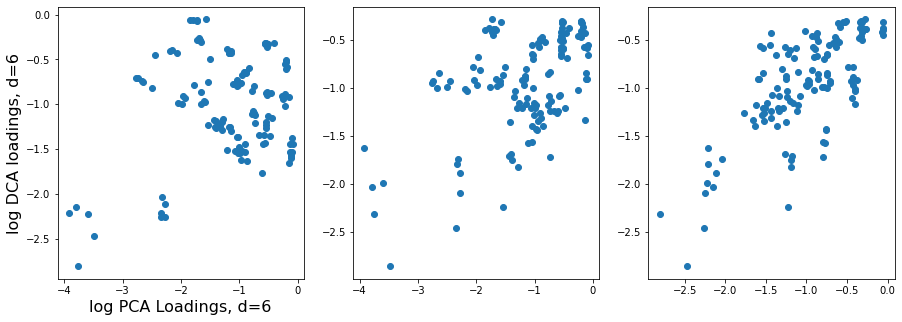

In [63]:
# Loadings
# Plot the r2 vs dim val
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# PCA
pca_loadings = np.zeros((dim_vals.size, n_cv, dat['spike_rates'].shape[-1]))
dca_loadings = np.zeros((len(T), dim_vals.size, n_cv, dat['spike_rates'].shape[-1]))
kca_loadings = np.zeros((len(T), dim_vals.size, n_cv, dat['spike_rates'].shape[-1]))

for i, dim_val in enumerate(dim_vals):
    for j in range(n_cv):
        dimreduc_df_ = apply_df_filters(dimreduc_df, 
                                decoding_window=decoding_window, 
                                bin_width=bin_width,
                                filter='none')
        
        pca_df = apply_df_filters(dimreduc_df_, T=1, fold_idx=j, dim_val=dim_val, )
        try:
            assert(pca_df.shape[0] == 1)
        except:
            pdb.set_trace()
        pca_loadings[i, j, :] = pca_df.iloc[0]['pca_loadings']
        for k, T_ in enumerate(T):
            dca_df = apply_df_filters(dimreduc_df_, T=T_, fold_idx=j, dim_val=dim_val)
            dca_loadings[k, i, j, :] = dca_df.iloc[0]['dca_loadings']
            kca_loadings[k, i, j, :] = dca_df.iloc[0]['kca_loadings']
            assert(dca_df.shape[0] == 1)              

ax[0].scatter(np.log(pca_loadings[5, ...].ravel()), np.log(dca_loadings[1, 5, ...].ravel()))
ax[0].set_xlabel('log PCA Loadings, d=6', fontsize=16)
ax[0].set_ylabel('log DCA loadings, d=6', fontsize=16)

ax[1].scatter(np.log(pca_loadings[5, ...].ravel()), np.log(kca_loadings[1, 5, ...].ravel()))
ax[2].scatter(np.log(dca_loadings[1, 5, ...].ravel()), np.log(kca_loadings[1, 5, ...].ravel()))


#plt.legend(['PCA', 'DCA T = 1'], loc='lower right', fontsize=14)



#ax.plot(dim_vals, np.mean(pca_r2, axis=-1))
#ax.plot(dim_vals, np.mean(dca_r2[0, ...], axis=-1))
# ax.plot(dim_vals, np.mean(dca_r2[1, ...], axis=-1))
# ax.plot(dim_vals, np.mean(dca_r2[2, ...], axis=-1))

In [ ]:
# How many neurons survive the 200 spike threshold across epochs?

In [65]:
units_retained = []
for epoch in [2, 4, 6, 8, 10, 12, 14, 16]:
    dat = load_peanut(fpath, epoch, spike_threshold=200)
    units_retained.append(dat['spike_rates'].shape[1])

In [66]:
units_retained

[27, 30, 26, 33, 33, 30, 31, 28]